# Microwave frequency selective surface

A Frequency Selective Surface (FSS) is a type of electromagnetic structure that allows certain frequencies to pass through while reflecting or blocking other frequencies. It is composed of a periodic array of conductive or dielectric elements that are spaced apart at a distance that is much smaller than the wavelength of the electromagnetic radiation. The FSS can be designed to selectively filter and manipulate the electromagnetic waves that pass through it based on the geometry, spacing, and material properties of its constituent elements. It is often used as a passive component in microwave and millimeter-wave devices, such as antennas, radars, filters, and absorbers.

This notebook provides a demonstration of a microwave FSS composed of copper cross structures. The copper is defined as [LossyMetalMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LossyMetalMedium.html), which is modeled as surface impedance boundary condition (SIBC). It works accurately even though the copper layer is very thin compared to the wavelength (~2.5 cm), and hence the grid step size around the copper layer, so it's computational efficiency. The FSS has been designed to exhibit a stop band at 12 GHz, where the transmission (S21) reaches as low as -50 dB. By visualizing the field distribution at the resonant frequency, we can observe the dipolar resonance feature of the copper structure. This simulation showcases the effectiveness of FSSs as passive components in microwave devices, and their ability to manipulate electromagnetic waves with high precision.

<img src="img/frequency_selective_surface.png" width="500" alt="Schematic of the FSS">

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
import tidy3d.web as web

## Simulation Setup

The default frequency unit in `Tidy3D` is Hz. For convenience, we prefer to work with GHz in this example. A frequency range from 10 GHz to 14 GHz is studied while the FSS is designed to resonate at 12 GHz.

In [2]:
GHz = 1e9  # 1 GHz = 1e9 Hz

freq_low, freq_high = 10 * GHz, 14 * GHz
freq0 = 12 * GHz  # central frequency
freqs = np.linspace(freq_low, freq_high, 500)  # frequency range of interest

fwidth = 0.5 * (freq_high - freq_low)  # width of the source spectrum

lda0 = td.C_0 / freq0  # central wavelength

The default length unit in Tidy3D is $\mu m$. For convenience, we prefer to work with mm in this example. Here we define the geometric parameters such as the length and width of the cross structure.

In [3]:
mm = 1e3  # 1 mm = 1e3 um
P = 15 * mm  # periodicity of the unit cell
L = 9.4 * mm  # length of the cross
W = 2 * mm  # width of the cross
t_sub = 2.2 * mm  # thickness of the substrate
t_copper = 0.1 * mm  # thickness of the copper layer

The copper is modeled as [LossyMetalMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LossyMetalMedium.html), or SIBC internally. We don't need to use very fine grid to resolve the actual thickness of the copper layer, as long as the copper layer is at the primal grid along the thickness dimension. The conductivity of copper is about $5\times 10^7$ S/m, which is 50 S/$\mu m$.

In [4]:
sigma_copper = 50  # copper conductivity in S/um
copper = rf.LossyMetalMedium(conductivity=sigma_copper, frequency_range=(freq_low, freq_high))

eps_sub = 2.5  # permittivity of the substrate
sub_medium = td.Medium(permittivity=eps_sub)  # define substrate medium

In [5]:
cross = []
cross.append(
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-L / 2, -W / 2, t_sub), rmax=(L / 2, W / 2, t_sub + t_copper)
        ),
        medium=copper,
    )
)
cross.append(
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-W / 2, -L / 2, t_sub), rmax=(W / 2, L / 2, t_sub + t_copper)
        ),
        medium=copper,
    )
)

substrate = td.Structure(
    geometry=td.Box(center=(0, 0, t_sub / 2), size=(td.inf, td.inf, t_sub)),
    medium=sub_medium,
)

A [PlaneWave](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html) source polarized in the x direction is added as the incident wave from the top of the FSS. To measure reflection (S11) and transmission (S21), two [FluxMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) are added on the top and bottom of the simulation domain. Lastly, to visualize the resonant mode field, a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) is added to the copper layer plane.

In [6]:
offset = lda0 / 2  # extra spacing added in the positive and negative z directions

# define a plane wave source
plane_wave = td.PlaneWave(
    center=(0, 0, t_sub + 0.1 * offset),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
)

# define a flux monitor to measure reflection
S11_monitor = td.FluxMonitor(
    center=(0, 0, t_sub + offset),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    name="S11",
)

# define a flux monitor to measure reflection
S21_monitor = td.FluxMonitor(
    center=(0, 0, -t_sub - offset),
    size=(td.inf, td.inf, 0),
    freqs=freqs,
    name="S21",
    normal_dir="-",
)

# define a field monitor to visualize field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, t_sub), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

With the previously defined structures, source, and monitors, we are ready to define a `Tidy3D` [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html). Periodic boundary condition is applied in the $x$ and $y$ directions while [PML](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PML.html) is applied in the $z$ direction. 

We also set up automatic nonuniform grids. In addition, we use [LayerRefinementSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) to refine mesh around corners.

In [7]:
# simulation domain size in z
Lz = t_sub + 2.2 * offset

# define a BoundarySpec
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PML(), plus=td.PML()),
)

# define a GridSpec
layer_spec = rf.LayerRefinementSpec.from_structures(
    axis=2,
    structures=cross,
    corner_refinement=td.GridRefinement(refinement_factor=5),
)

grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=30,
    layer_refinement_specs=[layer_spec],
    wavelength=lda0,
)

run_time = 1e-8  # simulation run time

# define simulation
sim = td.Simulation(
    size=(P, P, Lz),
    grid_spec=grid_spec,
    structures=[substrate] + cross,
    sources=[plane_wave],
    monitors=[S11_monitor, S21_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=boundary_spec,
    symmetry=(-1, 1, 0),  # symmetry is used to reduce the computational load
    subpixel=td.SubpixelSpec(
        lossy_metal=td.SurfaceImpedance(edge_singularity_correction=True)
    ),  # edge singularity correction for faster convergence
)

17:47:23 EST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 1 WARNING message.                             

             WARNING:  ℹ️ ⚠️ RF simulations are subject to new license            
             requirements in the future. You are using RF-specific components in
             this simulation.                                                   
              - Contains a 'LossyMetalMedium'.                                  
              - Contains sources defined for RF wavelengths.                    
              - Contains monitors defined for RF wavelengths.                   

In [8]:
print(sim.grid_info)

{'Nx': 58, 'Ny': 58, 'Nz': 64, 'grid_points': 215296, 'min_grid_size': 124.91352416666632, 'max_grid_size': 832.7568277777791, 'computational_complexity': 1723.5603705547571}


Before submitting the simulation job to the server, we can validate the simulation setup by plotting it. Here we overlay the grids on top to make sure the grid is sufficiently fine compared to the structure sizes.

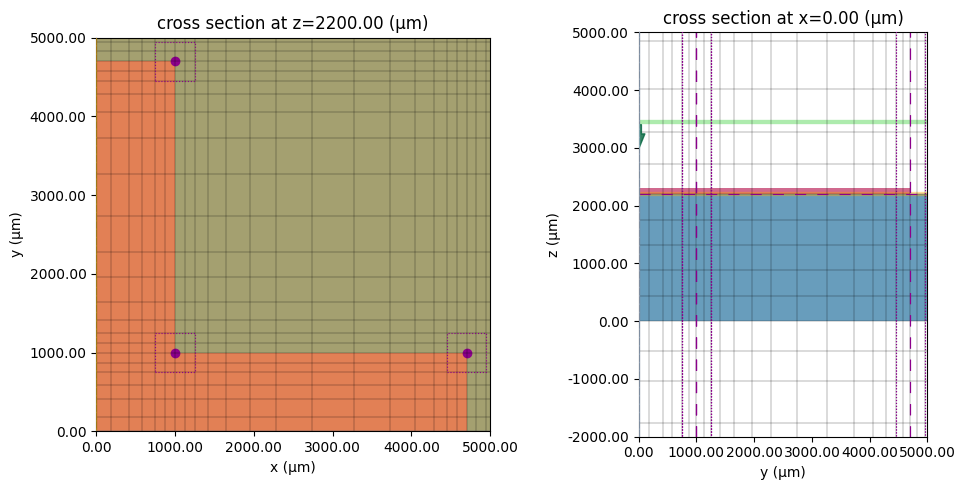

In [9]:
f, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
sim.plot(z=t_sub, ax=ax[0])
sim.plot_grid(z=t_sub, ax=ax[0])
ax[0].set_xlim(0, 5000)
ax[0].set_ylim(0, 5000)

sim.plot(x=0, ax=ax[1])
sim.plot_grid(x=0, ax=ax[1])
ax[1].set_xlim(0, 5000)
ax[1].set_ylim(-2000, 5000)
plt.show()

Submit the simulation job to the server.

In [10]:
job = web.Job(simulation=sim, task_name="frequency_selective_surface")
sim_data = job.run(path="data/simulation_data.hdf5")

17:47:24 EST Created task 'frequency_selective_surface' with resource_id        
             'fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=985304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=122252;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\taskId]8;;\]8;id=985304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\=]8;;\]8;id=237109;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\fdve]8;;\]8;id=985304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\-c804006f-29c]8;;\
             ]8;id=985304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\e-4dc0-a51e-2a6cb9fbffbd']8;;\.

             Task folder: ]8;id=341458;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

17:47:34 EST Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:47:35 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:47:58 EST status = preprocess

17:48:01 EST status = postprocess

17:48:03 EST status = success

17:48:05 EST starting up solver

             running solver

Output()

17:48:06 EST early shutoff detected at 16%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=491229;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=108723;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\taskId]8;;\]8;id=491229;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\=]8;;\]8;id=272558;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\fdve]8;;\]8;id=491229;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\-c804006f-29c]8;;\
             ]8;id=491229;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c804006f-29ce-4dc0-a51e-2a6cb9fbffbd\e-4dc0-a51e-2a6cb9fbffbd']8;;\.

Output()

17:48:07 EST Loading simulation from data/simulation_data.hdf5

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

## Result Visualization 

After the simulation is complete, we first visualize the S-parameters. A prominent resonance feature is observed at 12 GHz where S21 reaches -50 dB. 

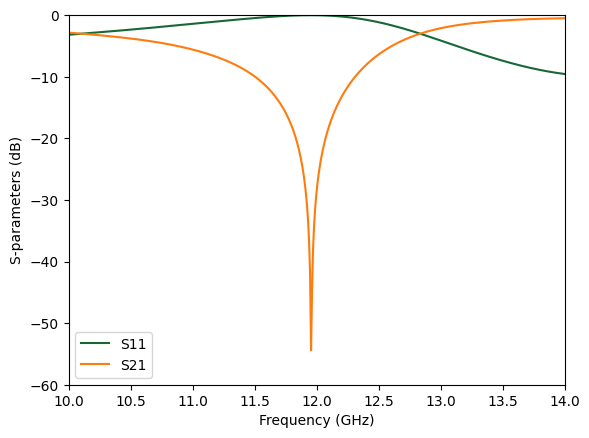

In [11]:
S11 = sim_data["S11"].flux
S21 = sim_data["S21"].flux

plt.plot(freqs / GHz, 10 * np.log10(S11), label="S11")
plt.plot(freqs / GHz, 10 * np.log10(S21), label="S21")
plt.xlim(10, 14)
plt.ylim(-60, 0)
plt.xlabel("Frequency (GHz)")
plt.ylabel("S-parameters (dB)")
plt.legend()
plt.show()

Lastly, we plot the field intensity distribution at the resonant frequency. A strong dipolar field pattern is observed in the horizontal copper pattern. This dipolar resonance is responsible for the total reflection of the electromagnetic wave at this frequency.

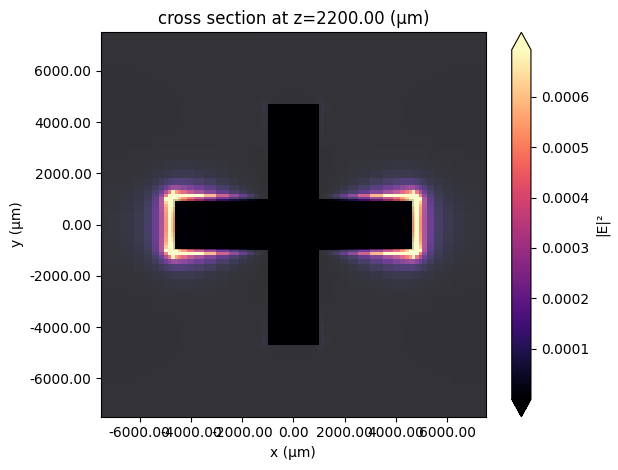

In [12]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()